In [24]:
import json
import requests
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
import pandas as pd
import seaborn as sns 
import itertools

In [25]:
search_topics = ['Chemistry','Oceans','Lithosphere','Biological Classification','Paleontology','Atmosphere','Ecology',
                 'Land Surface','Geophysics','Agriculture']
max_dataset = 100
pangaea_service = 'http://ws.pangaea.de/es/pangaea/panmd/_search?q=agg-mainTopic:'
fuji_service = 'http://seprojects.marum.de:1071/fuji/api/v1/evaluate'
datasets = []
data_dir = 'results'

In [26]:
metrics = []
try:
    request = requests.get('http://seprojects.marum.de:1071/fuji/api/v1/metrics',headers={'Content-Type': 'application/json'}, auth=('marvel', 'wonderwoman'))
    mm = request.json()['metrics']
    for m in mm:
        metrics.append({k: m[k] for k in ('metric_identifier', 'metric_name', 'total_score')})
except requests.exceptions.RequestException as e:
    print(e)
except requests.exceptions.ConnectionError as e1:
    print(e1)

In [27]:
df_metrics = pd.DataFrame.from_dict(metrics)
df_metrics

,metric_identifier,metric_name,total_score
0,FsF-F1-01D,Data is assigned with a globally unique identi...,1
1,FsF-F1-02D,Data is assigned with a persistent identifier.,1
2,FsF-F2-01M,Metadata include descriptive core elements (cr...,2
3,FsF-F3-01M,Metadata includes the identifier of the data i...,2
4,FsF-F4-01M,Metadata is offered in such a way that it can ...,3
5,FsF-A1-01M,Metadata contains the access level and access ...,1
6,FsF-I1-01M,Metadata is represented using a formal knowled...,2
7,FsF-I1-02M,Metadata uses common semantic resources,1
8,FsF-I3-01M,Metadata includes links between the data and i...,1
9,FsF-R1-01MD,Metadata includes the descriptions of the cont...,4


In [28]:
#http://ws.pangaea.de/es/pangaea/panmd/_search?q=agg-mainTopic:Chemistry
for s in search_topics:
    try:
        req = requests.get(pangaea_service+s)
        raw = req.json()
        hits = raw['hits']['hits']
        for h in hits:
            #print(h['_source']['URI'])
            datasets.append(h['_source']['URI'])
    except requests.exceptions.RequestException as e:
        print(e)
    except requests.exceptions.ConnectionError as e1:
        print(e1)

In [29]:
print('Total datasets :', len(datasets))

Total datasets : 100


In [30]:
datasets[:10]

['https://doi.org/10.1594/PANGAEA.816767',
 'https://doi.org/10.1594/PANGAEA.838420',
 'https://doi.org/10.1594/PANGAEA.866702',
 'https://doi.org/10.1594/PANGAEA.728443',
 'https://doi.org/10.1594/PANGAEA.351146',
 'https://doi.org/10.1594/PANGAEA.815490',
 'https://doi.org/10.1594/PANGAEA.855771',
 'https://doi.org/10.1594/PANGAEA.669618',
 'https://doi.org/10.1594/PANGAEA.54368',
 'https://doi.org/10.1594/PANGAEA.84137']

In [31]:
%%time
all_records = []
if len(datasets) == 100:
    for d in datasets:
        req = {'object_identifier':d, 'test_debug':True}
        r = requests.post(fuji_service, data=json.dumps(req), headers={'Content-Type': 'application/json'}, auth=('marvel', 'wonderwoman'))
        json_data = r.json()
        records = {}
        records['identifier'] = d
        records['result'] = json_data
        all_records.append(records)

Wall time: 6min 18s


In [32]:
with open(data_dir+'/'+'pangaea.json', 'w') as f:
    json.dump(all_records, f)

In [33]:
with open(data_dir+'/'+'pangaea.json') as json_file:
    data = json.load(json_file)

In [34]:
def get_assessment_result(id):
    jsn = None
    for data_dict in data:
        if data_dict['identifier'] == id:
            jsn = data_dict['result']
    return jsn

In [35]:
get_assessment_result('https://doi.org/10.1594/PANGAEA.816767')

[{'id': 1,
  'metric_identifier': 'FsF-F1-01D',
  'metric_name': 'Data is assigned with a globally unique identifier.',
  'output': {'guid': 'https://doi.org/10.1594/PANGAEA.816767',
   'guid_scheme': 'doi'},
  'score': {'earned': 1, 'total': 1},
  'test_debug': ["INFO: Unique identifier schemes found ['doi', 'url']",
   'INFO: Finalized unique identifier scheme - doi'],
  'test_status': 'pass'},
 {'id': 2,
  'metric_identifier': 'FsF-F1-02D',
  'metric_name': 'Data is assigned with a persistent identifier.',
  'output': {'pid': 'https://doi.org/10.1594/PANGAEA.816767',
   'pid_scheme': 'doi',
   'resolvable_status': True,
   'resolved_url': 'https://doi.pangaea.de/10.1594/PANGAEA.816767'},
  'score': {'earned': 1, 'total': 1},
  'test_debug': ['INFO: Persistence identifier scheme - doi',
   'INFO: Retrieving page http://doi.org/10.1594/PANGAEA.816767',
   'INFO: Content negotiation accept=text/html, application/xhtml+xml, status=200',
   'INFO: Found HTML page!',
   'INFO: Object iden

In [36]:
final = []
for data_dict in data:
    results = {}
    results['identifier'] = data_dict['identifier']
    dd = data_dict['result'] # list of dict
    for d in dd:
        metric_identifier = d['metric_identifier']
        sub_principle = metric_identifier.split('-')[1]
        principle = sub_principle[0]+'_earned'
        principle_total = sub_principle[0]+'_total'
        if not sub_principle in results:
            results[sub_principle] = d['score']['earned']
        else:
            results[sub_principle] += d['score']['earned']
        if not principle in results:
            results[principle] = d['score']['earned']
        else:
            results[principle] += d['score']['earned']
        if not principle_total in results:
            results[principle_total] = d['score']['total']
        else:
            results[principle_total] += d['score']['total']
    final.append(results)

In [37]:
df_results = pd.DataFrame.from_dict(final)

In [38]:
cols = ['identifier','F1','F2','F3','F4','A1','A1','I1','I3','R1','R1.1','R1.2','R1.3','F_earned','F_total','A_earned','A_total','I_earned','I_total','R_earned','R_total']
df_results = df_results[cols]

In [39]:
df_results.head()

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,R1.2,R1.3,F_earned,F_total,A_earned,A_total,I_earned,I_total,R_earned,R_total
0,https://doi.org/10.1594/PANGAEA.816767,2,1,1,3,0,0,1,1,3,...,0.5,2,7,9,0,1,2,4,6.5,9
1,https://doi.org/10.1594/PANGAEA.838420,2,2,1,3,0,0,1,1,3,...,1.0,2,8,9,0,1,2,4,7.0,9
2,https://doi.org/10.1594/PANGAEA.866702,2,2,1,3,0,0,1,1,3,...,1.0,2,8,9,0,1,2,4,7.0,9
3,https://doi.org/10.1594/PANGAEA.728443,2,1,1,3,0,0,1,1,3,...,1.0,2,7,9,0,1,2,4,7.0,9
4,https://doi.org/10.1594/PANGAEA.351146,2,2,1,3,0,0,1,1,3,...,1.0,2,8,9,0,1,2,4,7.0,9


In [40]:
df_results ['F_Principle'] = (df_results ['F_earned'] / df_results ['F_total'] * 100).round()
df_results ['A_Principle'] = (df_results ['A_earned'] / df_results ['A_total'] * 100).round()
df_results ['I_Principle'] = (df_results ['I_earned'] / df_results ['I_total'] * 100).round()
df_results ['R_Principle' ]= (df_results ['I_total'] / df_results ['R_total'] * 100).round()

In [41]:
df_results.head()

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,A_earned,A_total,I_earned,I_total,R_earned,R_total,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.1594/PANGAEA.816767,2,1,1,3,0,0,1,1,3,...,0,1,2,4,6.5,9,78.0,0.0,50.0,44.0
1,https://doi.org/10.1594/PANGAEA.838420,2,2,1,3,0,0,1,1,3,...,0,1,2,4,7.0,9,89.0,0.0,50.0,44.0
2,https://doi.org/10.1594/PANGAEA.866702,2,2,1,3,0,0,1,1,3,...,0,1,2,4,7.0,9,89.0,0.0,50.0,44.0
3,https://doi.org/10.1594/PANGAEA.728443,2,1,1,3,0,0,1,1,3,...,0,1,2,4,7.0,9,78.0,0.0,50.0,44.0
4,https://doi.org/10.1594/PANGAEA.351146,2,2,1,3,0,0,1,1,3,...,0,1,2,4,7.0,9,89.0,0.0,50.0,44.0


In [42]:
df_hist = df_results[['identifier','F_Principle','A_Principle','I_Principle','R_Principle']]
df_hist

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.1594/PANGAEA.816767,78.0,0.0,50.0,44.0
1,https://doi.org/10.1594/PANGAEA.838420,89.0,0.0,50.0,44.0
2,https://doi.org/10.1594/PANGAEA.866702,89.0,0.0,50.0,44.0
3,https://doi.org/10.1594/PANGAEA.728443,78.0,0.0,50.0,44.0
4,https://doi.org/10.1594/PANGAEA.351146,89.0,0.0,50.0,44.0
...,...,...,...,...,...
95,https://doi.org/10.1594/PANGAEA.882209,78.0,0.0,50.0,44.0
96,https://doi.org/10.1594/PANGAEA.909132,89.0,0.0,50.0,44.0
97,https://doi.org/10.1594/PANGAEA.787167,89.0,0.0,50.0,44.0
98,https://doi.org/10.1594/PANGAEA.838665,89.0,0.0,50.0,44.0


In [47]:
df_hist[df_hist.A_Principle >50]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
23,https://doi.org/10.1594/PANGAEA.825551,67.0,100.0,50.0,44.0
47,https://doi.org/10.1594/PANGAEA.886576,78.0,100.0,50.0,44.0
50,https://doi.org/10.1594/PANGAEA.667522,67.0,100.0,50.0,44.0
53,https://doi.org/10.1594/PANGAEA.788832,67.0,100.0,50.0,44.0
55,https://doi.org/10.1594/PANGAEA.723018,78.0,100.0,50.0,44.0
56,https://doi.org/10.1594/PANGAEA.676813,78.0,100.0,50.0,44.0
57,https://doi.org/10.1594/PANGAEA.724248,67.0,100.0,50.0,44.0
58,https://doi.org/10.1594/PANGAEA.721230,78.0,100.0,50.0,44.0
59,https://doi.org/10.1594/PANGAEA.879478,78.0,100.0,50.0,44.0


Text(0.5, 0, 'FAIR Score')

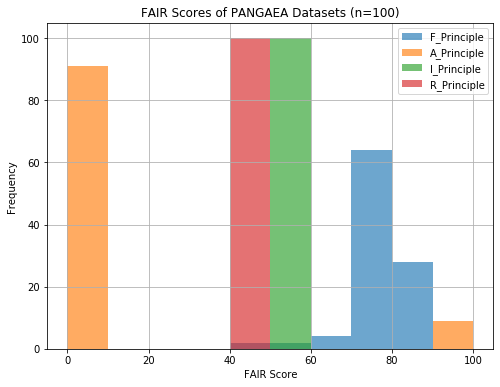

In [44]:
df_hist.plot.hist(sharex=True,sharey=True,alpha=0.65,figsize = (8,6), title="FAIR Scores of PANGAEA Datasets (n=100)")
plt.xlabel('FAIR Score')

In [45]:
def histograms_plot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(10,10))
    # set palette 
    palette = itertools.cycle(sns.color_palette())
    for i, feature in enumerate(features):
        c = next(palette)
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].plot.hist(bins=10, ax=ax, color=c)
        ax.set_title("FAIR Score - "+feature+ ' (n=' + str(len(df_hist))+')')
        ax.set(xlabel="Score", ylabel="Frequency")
    fig.tight_layout()  
    plt.show()

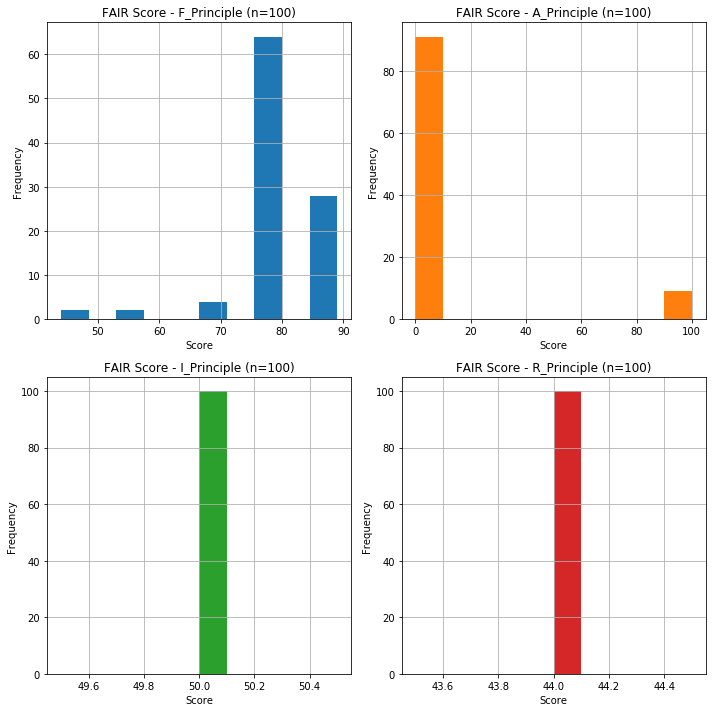

In [46]:
histograms_plot(df_hist,df_hist.columns[1:],2,2)